In [783]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

In [784]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')


marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

merged_df = customers.join(engagement).join(transactions_agg).join(marketing_agg)
merged_df

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


In [785]:
# Feature Engineering 

merged_df['average_spend_total'] = merged_df['transaction_amount']/merged_df['transaction_id']
merged_df['Monetary_tier'] = pd.qcut(merged_df['transaction_amount'], 3, labels=['low','medium','high'])


merged_df['join_date'] = pd.to_datetime(merged_df['join_date'])
merged_df['last_purchase_date'] = pd.to_datetime(merged_df['last_purchase_date'])
merged_df['customer_age'] = merged_df['last_purchase_date'] - merged_df['join_date']

merged_df['customer_age'] = merged_df['customer_age'].dt.days



In [786]:
scaler = MinMaxScaler()


In [787]:
engagement_df = merged_df[['number_of_clicks', 'number_of_site_visits', 'number_of_emails_opened']] 
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   number_of_clicks         10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
dtypes: int64(3)
memory usage: 312.5 KB


In [788]:
# Combining engagement features into one score
engagement_df = merged_df[['number_of_clicks', 'number_of_site_visits', 'number_of_emails_opened']] 
n_engagement_df = pd.DataFrame(scaler.fit_transform(engagement_df), columns=engagement_df.columns)
n_engagement_df['engagement_score'] = n_engagement_df.sum(axis=1)

low_threshold = n_engagement_df['engagement_score'].quantile(0.33)
medium_threshold = n_engagement_df['engagement_score'].quantile(0.66)

def assign_tier(score):
    if score <= low_threshold:
        return 'low'
    elif score <= medium_threshold:
        return 'medium'
    else:
        return 'high'


n_engagement_df['engagement_tier'] = n_engagement_df['engagement_score'].apply(assign_tier)
n_engagement_df.index = n_engagement_df.index + 1
n_engagement_df

,number_of_clicks,number_of_site_visits,number_of_emails_opened,engagement_score,engagement_tier
1,0.000000,0.012676,0.046358,0.059034,low
2,0.354610,0.400000,0.158940,0.913550,high
3,0.170213,0.269014,0.238411,0.677637,high
4,0.113475,0.153521,0.096026,0.363023,medium
5,0.042553,0.225352,0.003311,0.271217,medium
...,...,...,...,...,...
9996,0.106383,0.166197,0.152318,0.424898,medium
9997,0.092199,0.002817,0.105960,0.200976,medium
9998,0.028369,0.073239,0.052980,0.154588,medium
9999,0.021277,0.030986,0.013245,0.065508,low


In [789]:
merged_df[['engagement_score', 'engagement_tier']] = n_engagement_df[['engagement_score', 'engagement_tier']]
merged_df

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_spend_total,Monetary_tier,customer_age,engagement_score,engagement_tier
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,584.913333,low,118,0.059034,low
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,675.702222,medium,777,0.913550,high
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,242.478333,low,544,0.677637,high
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,393.734000,medium,243,0.363023,medium
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,646.856250,high,494,0.271217,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,549.820000,medium,240,0.424898,medium
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,487.358333,medium,200,0.200976,medium
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,1167.710000,low,135,0.154588,medium


In [790]:
# Categorical Modeling for tiered variables
def category_function(x):
    if x == 'low':
        return 1
    elif x == 'medium':
        return 2
    elif x == 'high':
        return 3
    
merged_df['engage_tier_number'] = merged_df['engagement_tier'].apply(category_function)
merged_df['monetary_tier_number'] = merged_df['Monetary_tier'].apply(category_function)

merged_df

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_spend_total,Monetary_tier,customer_age,engagement_score,engagement_tier,engage_tier_number,monetary_tier_number
customer_id,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,584.913333,low,118,0.059034,low,1,1
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,675.702222,medium,777,0.913550,high,3,2
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,242.478333,low,544,0.677637,high,3,1
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,393.734000,medium,243,0.363023,medium,2,2
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,646.856250,high,494,0.271217,medium,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,549.820000,medium,240,0.424898,medium,2,2
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,487.358333,medium,200,0.200976,medium,2,2
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,1167.710000,low,135,0.154588,medium,2,1


In [791]:
merged_df['Monetary_tier'].info()

<class 'pandas.core.series.Series'>
Index: 10000 entries, 1 to 10000
Series name: Monetary_tier
Non-Null Count  Dtype   
--------------  -----   
10000 non-null  category
dtypes: category(1)
memory usage: 88.0 KB


In [792]:
#Add some graphs

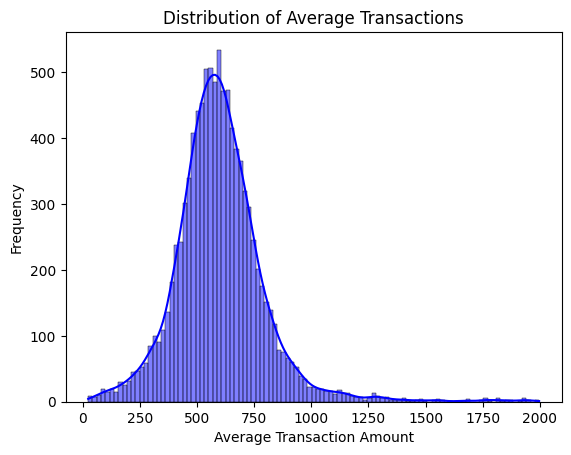

In [793]:
# Histogram to determine data distribution
sns.histplot(merged_df['average_spend_total'], kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Average Transactions')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [794]:
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [795]:
max_date = transactions['transaction_date'].max()

In [796]:
# TEMPORAL SPLITTING -- Split Data to train model using everything before 90 days of the most recent date

n_days = 90

cutoff = max_date - pd.to_timedelta(n_days, unit="d")

In [797]:
data_in_df = transactions[transactions['transaction_date'] <= cutoff] #Using this to predict the output -- Any date before the cutoff
data_out_df = transactions[transactions['transaction_date'] > cutoff] #Predicting the output --Any Date after the cutoff

In [798]:
#Another time segment to capture last 360 days of transaction history -- aggregated
date_amount = 360

cutoff2 = max_date - pd.Timedelta(days=date_amount)

t_range_360 = transactions[(transactions['transaction_date'] >= cutoff2) & (transactions['transaction_date'] < max_date)] #June 6, 2023 - May 31, 2024 
t_range_360


,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics
...,...,...,...,...,...
129539,129540,10000,2023-07-20,310.95,Clothing
129541,129542,10000,2023-06-11,1245.23,Electronics
129542,129543,10000,2023-06-28,745.74,Electronics
129543,129544,10000,2023-07-21,587.37,Home Goods


In [799]:
t_range_360 = t_range_360.drop(columns='product_category')
t_range_360

,transaction_id,customer_id,transaction_date,transaction_amount
0,1,1,2024-02-03,165.56
1,2,1,2024-03-02,699.01
2,3,1,2024-03-12,146.86
3,4,1,2024-01-20,927.46
4,5,1,2024-02-25,1395.87
...,...,...,...,...
129539,129540,10000,2023-07-20,310.95
129541,129542,10000,2023-06-11,1245.23
129542,129543,10000,2023-06-28,745.74
129543,129544,10000,2023-07-21,587.37


In [800]:
t_range_360['transaction_date'].describe()

count                            44454
mean     2023-12-07 10:18:11.321366016
min                2023-06-06 00:00:00
25%                2023-09-09 00:00:00
50%                2023-12-10 00:00:00
75%                2024-03-08 00:00:00
max                2024-05-30 00:00:00
Name: transaction_date, dtype: object

## RFM SEGMENTATION

In [801]:
def calculate_rfm(data, end_date, days_label):
    rfm = data.groupby('customer_id').agg(
        recency = ('transaction_date', lambda x: (end_date - x.max()).days),
        frequency = ('transaction_id', 'count'),
        monetary = ('transaction_amount', 'sum')
    ).rename(columns={
        'recency': f'Recency_{days_label}',
        'frequency': f'Frequency_{days_label}',
        'monetary': f'Monetary_{days_label}'
    })
    return rfm

In [802]:
rfm360_df = calculate_rfm(t_range_360, max_date, '360')
rfm360_df

,Recency_360,Frequency_360,Monetary_360
customer_id,,,
1,80,6,3509.48
7,13,5,1339.82
8,305,7,4693.03
9,306,1,252.74
12,150,5,3221.32
...,...,...,...
9991,30,25,19857.11
9992,119,18,12543.37
9996,355,3,1096.25


In [803]:
# Assign RFM scores (using quintiles)
rfm360_df['recency_score'] = pd.qcut(rfm360_df['Recency_360'], 5, labels=[5, 4, 3, 2, 1],duplicates='drop')
rfm360_df['frequency_score'] = pd.qcut(rfm360_df['Frequency_360'], 5, labels=[1, 2, 3, 4, 5],duplicates='drop')
rfm360_df['monetary_score'] = pd.qcut(rfm360_df['Monetary_360'], 5, labels=[1, 2, 3, 4, 5],duplicates='drop')

# Combine RFM scores into a single score
rfm360_df['RFM_score'] = rfm360_df[['recency_score', 'frequency_score', 'monetary_score']].sum(axis=1)

rfm360_df

,Recency_360,Frequency_360,Monetary_360,recency_score,frequency_score,monetary_score,RFM_score
customer_id,,,,,,,
1,80,6,3509.48,4,3,3,10
7,13,5,1339.82,5,2,2,9
8,305,7,4693.03,1,3,3,7
9,306,1,252.74,1,1,1,3
12,150,5,3221.32,3,2,3,8
...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,5,15
9992,119,18,12543.37,3,5,5,13
9996,355,3,1096.25,1,2,1,4


In [804]:
rfm360_df['CLV_category'] = pd.qcut(rfm360_df['RFM_score'], 3, labels=['low', 'medium', 'high'])
rfm360_df

,Recency_360,Frequency_360,Monetary_360,recency_score,frequency_score,monetary_score,RFM_score,CLV_category
customer_id,,,,,,,,
1,80,6,3509.48,4,3,3,10,medium
7,13,5,1339.82,5,2,2,9,medium
8,305,7,4693.03,1,3,3,7,low
9,306,1,252.74,1,1,1,3,low
12,150,5,3221.32,3,2,3,8,medium
...,...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,5,15,high
9992,119,18,12543.37,3,5,5,13,high
9996,355,3,1096.25,1,2,1,4,low


In [805]:
rfm360_df['CLV_category_number'] = rfm360_df['CLV_category'].apply(category_function)

In [806]:
rfm360_df = pd.merge(rfm360_df, merged_df[['join_date','customer_age', 'average_spend_total', 'transaction_id', 'last_purchase_date',\
                                            'engagement_score', 'engagement_tier', 'engage_tier_number','monetary_tier_number']],\
                                              on='customer_id', how='left')
rfm360_df

,Recency_360,Frequency_360,Monetary_360,recency_score,frequency_score,monetary_score,RFM_score,CLV_category,CLV_category_number,join_date,customer_age,average_spend_total,transaction_id,last_purchase_date,engagement_score,engagement_tier,engage_tier_number,monetary_tier_number
customer_id,,,,,,,,,,,,,,,,,,
1,80,6,3509.48,4,3,3,10,medium,2,2023-11-20,118,584.913333,6,2024-03-17,0.059034,low,1,1
7,13,5,1339.82,5,2,2,9,medium,2,2023-12-11,170,267.964000,5,2024-05-29,0.134127,low,1,1
8,305,7,4693.03,1,3,3,7,low,1,2023-02-09,181,780.708000,15,2023-08-09,0.195188,medium,2,3
9,306,1,252.74,1,1,1,3,low,1,2022-01-24,568,471.952727,22,2023-08-15,0.348522,medium,2,3
12,150,5,3221.32,3,2,3,8,medium,2,2021-05-08,1059,770.414167,12,2024-04-01,1.142732,high,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,5,15,high,3,2024-03-25,38,794.284400,25,2024-05-02,0.030691,low,1,3
9992,119,18,12543.37,3,5,5,13,high,3,2024-01-12,22,696.853889,18,2024-02-03,0.011268,low,1,3
9996,355,3,1096.25,1,2,1,4,low,1,2022-12-16,240,549.820000,10,2023-08-13,0.424898,medium,2,2


In [807]:
rfm360_df['average_spend_360'] = rfm360_df['Monetary_360'] / rfm360_df['Frequency_360']
rfm360_df

,Recency_360,Frequency_360,Monetary_360,recency_score,frequency_score,monetary_score,RFM_score,CLV_category,CLV_category_number,join_date,customer_age,average_spend_total,transaction_id,last_purchase_date,engagement_score,engagement_tier,engage_tier_number,monetary_tier_number,average_spend_360
customer_id,,,,,,,,,,,,,,,,,,,
1,80,6,3509.48,4,3,3,10,medium,2,2023-11-20,118,584.913333,6,2024-03-17,0.059034,low,1,1,584.913333
7,13,5,1339.82,5,2,2,9,medium,2,2023-12-11,170,267.964000,5,2024-05-29,0.134127,low,1,1,267.964000
8,305,7,4693.03,1,3,3,7,low,1,2023-02-09,181,780.708000,15,2023-08-09,0.195188,medium,2,3,670.432857
9,306,1,252.74,1,1,1,3,low,1,2022-01-24,568,471.952727,22,2023-08-15,0.348522,medium,2,3,252.740000
12,150,5,3221.32,3,2,3,8,medium,2,2021-05-08,1059,770.414167,12,2024-04-01,1.142732,high,3,2,644.264000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,5,15,high,3,2024-03-25,38,794.284400,25,2024-05-02,0.030691,low,1,3,794.284400
9992,119,18,12543.37,3,5,5,13,high,3,2024-01-12,22,696.853889,18,2024-02-03,0.011268,low,1,3,696.853889
9996,355,3,1096.25,1,2,1,4,low,1,2022-12-16,240,549.820000,10,2023-08-13,0.424898,medium,2,2,365.416667


In [808]:
rfm360_df.describe()

,Recency_360,Frequency_360,Monetary_360,RFM_score,join_date,customer_age,average_spend_total,transaction_id,last_purchase_date,engagement_score,engage_tier_number,average_spend_360
count,4990.000000,4990.000000,4990.000000,4990.000000,4990,4990.00000,4990.000000,4990.000000,4990,4990.000000,4990.000000,4990.000000
mean,160.632465,8.908617,5335.615112,8.936673,2022-12-31 20:34:49.298597376,384.78998,600.561993,13.497996,2024-01-20 15:32:23.567134208,0.378633,1.906613,600.440288
min,1.000000,1.000000,11.680000,3.000000,2020-01-04 00:00:00,0.00000,33.340000,1.000000,2023-06-07 00:00:00,0.000000,1.000000,11.680000
25%,68.000000,3.000000,1617.282500,6.000000,2022-05-21 06:00:00,73.00000,493.523750,8.000000,2023-11-06 00:00:00,0.054616,1.000000,449.370000
50%,152.000000,7.000000,4083.410000,9.000000,2023-04-26 00:00:00,245.00000,587.255962,13.000000,2024-02-06 00:00:00,0.216178,2.000000,580.067937
75%,247.750000,14.000000,8249.340000,12.000000,2023-11-12 00:00:00,593.75000,692.545658,20.000000,2024-04-15 00:00:00,0.558405,3.000000,716.095833
max,360.000000,25.000000,22364.720000,15.000000,2024-05-30 00:00:00,1580.00000,1990.290000,25.000000,2024-05-31 00:00:00,2.451381,3.000000,1990.290000
std,103.496766,7.026969,4443.269753,3.675012,NaN,386.03647,181.015905,6.993504,NaN,0.431236,0.835483,252.827559


## Classification Model

In [809]:
# Creating Binary output for model
# 75th percentile or better for the RFM score is used for binary output because we are trying to predict the highest value customers
rfm360_df['binary_output'] = rfm360_df['RFM_score'].apply(lambda x: 1 if x>=12 else 0)


In [810]:
rfm360_df

,Recency_360,Frequency_360,Monetary_360,recency_score,frequency_score,monetary_score,RFM_score,CLV_category,CLV_category_number,join_date,customer_age,average_spend_total,transaction_id,last_purchase_date,engagement_score,engagement_tier,engage_tier_number,monetary_tier_number,average_spend_360,binary_output
customer_id,,,,,,,,,,,,,,,,,,,,
1,80,6,3509.48,4,3,3,10,medium,2,2023-11-20,118,584.913333,6,2024-03-17,0.059034,low,1,1,584.913333,0
7,13,5,1339.82,5,2,2,9,medium,2,2023-12-11,170,267.964000,5,2024-05-29,0.134127,low,1,1,267.964000,0
8,305,7,4693.03,1,3,3,7,low,1,2023-02-09,181,780.708000,15,2023-08-09,0.195188,medium,2,3,670.432857,0
9,306,1,252.74,1,1,1,3,low,1,2022-01-24,568,471.952727,22,2023-08-15,0.348522,medium,2,3,252.740000,0
12,150,5,3221.32,3,2,3,8,medium,2,2021-05-08,1059,770.414167,12,2024-04-01,1.142732,high,3,2,644.264000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,5,15,high,3,2024-03-25,38,794.284400,25,2024-05-02,0.030691,low,1,3,794.284400,1
9992,119,18,12543.37,3,5,5,13,high,3,2024-01-12,22,696.853889,18,2024-02-03,0.011268,low,1,3,696.853889,1
9996,355,3,1096.25,1,2,1,4,low,1,2022-12-16,240,549.820000,10,2023-08-13,0.424898,medium,2,2,365.416667,0


In [811]:
rfm_360_X = rfm360_df[['average_spend_360', 'customer_age', 'CLV_category_number', 'engage_tier_number', 'monetary_tier_number']]
rfm_360_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4990 entries, 1 to 10000
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   average_spend_360     4990 non-null   float64 
 1   customer_age          4990 non-null   int64   
 2   CLV_category_number   4990 non-null   category
 3   engage_tier_number    4990 non-null   int64   
 4   monetary_tier_number  4990 non-null   category
dtypes: category(2), float64(1), int64(2)
memory usage: 165.9 KB


In [821]:
# Features and Output assignment
X_360 = rfm360_df[['average_spend_360', 'customer_age', 'CLV_category_number', 'engage_tier_number']]
y_360 = rfm360_df['binary_output']



In [827]:
# reserve 20% for testing
X_train_360, X_test_360, y_train_360, y_test_360 = train_test_split(X_360,y_360, test_size=0.3, random_state=42)

In [828]:
# build our pipeline that includes these transformations
numeric_columns_360 = ['average_spend_360', 'customer_age']
categorical_columns_360 = ['CLV_category_number', 'engage_tier_number']

In [829]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor360 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_360),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_360)
    ]
)

In [830]:
# we are going to test 3 models with cross validation to see which ones work best for this data
knn_360 = KNeighborsClassifier()
logreg_360 = LogisticRegression()
nb_360 = GaussianNB()

In [831]:
# cross validation to determine in general which model works best for the given problem
knn_scores_360 = cross_val_score(knn_360, X_train_360, y_train_360, scoring='f1', cv=5)
logreg_scores_360 = cross_val_score(logreg_360, X_train_360, y_train_360, scoring='f1', cv=5)
nb_scores_360 = cross_val_score(nb_360, X_train_360, y_train_360, scoring='f1', cv=5)

/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [832]:
print(np.mean(knn_scores_360))
print(np.mean(logreg_scores_360))
print(np.mean(nb_scores_360))

0.520915805911588
1.0
0.9924572434620844


In [826]:
X = rfm360_df[['recency_score', 'frequency_score', 'monetary_score']]
y = rfm360_df['CLV_category'] # Need to change this to a future RFM predictor 



## Regression Model to predict Purchase Volume

In [820]:
X = rfm360_df[['recency_score', 'frequency_score', 'monetary_score']]
y = rfm360_df['CLV'] # Need to change this to a future RFM predictor 


KeyError: 'CLV'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_2 = RandomForestRegressor(n_estimators=100,random_state=42)
model_2.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model_2.predict(X_test)
y_pred

array([ 8218.016951  ,  8504.80688368,  6507.11429217,  7078.81868726,
        9786.49732578,  7842.32644863,  7253.69992255,  9497.91040571,
        6045.87535625,  4347.9165366 , 13144.18257446,  7842.32644863,
        2964.34551308,  4531.55324813, 12125.56066475,  6621.20739333,
        7016.25579788,  7355.91595562, 13144.18257446, 12125.56066475,
        8063.96333801,  8972.05234583,  5843.52883955,  7565.51453194,
        7879.14494002,  6776.76987139,  4347.9165366 ,  7016.25579788,
        7355.91595562,  7282.70165502,  7842.32644863,  9786.49732578,
        8689.33497969,  6045.87535625,  8063.96333801,  9295.97595856,
       11873.37971645,  7159.26465342,  2964.34551308,  7355.91595562,
        8816.50248543,  8629.57036332,  8063.96333801, 10058.73735939,
        7078.81868726,  2964.34551308,  4822.97152258, 11393.472261  ,
        6621.20739333, 10881.70676023, 10796.14796382,  7355.91595562,
       10058.73735939, 13144.18257446,  7104.77833518,  8972.05234583,
      

In [ ]:
# Evaluate the model - Right now this model looks close to perfect which is incorrect
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 2698.9161073877326
Mean Squared Error (MSE): 11150083.746730866
Root Mean Squared Error (RMSE): 3339.174111472905
R-squared (R²): 0.45339224094471975


In [ ]:
scores = cross_val_score(model_2, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Cross-Validation MAE: ", -scores.mean())

Cross-Validation MAE:  2665.0917457048226
